In [ ]:
# Import các thư viện
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score
import os
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Tải,trực quan hoá và chuẩn hoá dữ liệu

Upload dataset


unarchive

In [ ]:
!unzip dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: dataset/euro_50/euro_50_181.jpg  
  inflating: dataset/euro_50/euro_50_182.jpg  
  inflating: dataset/euro_50/euro_50_183.jpg  
  inflating: dataset/euro_50/euro_50_184.jpg  
  inflating: dataset/euro_50/euro_50_185.jpg  
  inflating: dataset/euro_50/euro_50_186.jpg  
  inflating: dataset/euro_50/euro_50_187.jpg  
  inflating: dataset/euro_50/euro_50_188.jpg  
  inflating: dataset/euro_50/euro_50_189.jpg  
  inflating: dataset/euro_50/euro_50_19.jpg  
  inflating: dataset/euro_50/euro_50_190.jpg  
  inflating: dataset/euro_50/euro_50_191.jpg  
  inflating: dataset/euro_50/euro_50_192.jpg  
  inflating: dataset/euro_50/euro_50_193.jpg  
  inflating: dataset/euro_50/euro_50_194.jpg  
  inflating: dataset/euro_50/euro_50_195.jpg  
  inflating: dataset/euro_50/euro_50_196.jpg  
  inflating: dataset/euro_50/euro_50_197.jpg  
  inflating: dataset/euro_50/euro_50_198.jpg  
  inflating: dataset/euro_50/euro_50_199.jpg  
  in

Chia tập test train valid

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Đường dẫn dữ liệu gốc và nơi lưu mới
source_dir = '/content/dataset'
target_base_dir = '/content/dataset_split'

# Tỉ lệ chia
train_ratio = 0.75
val_ratio = 0.15
test_ratio = 0.1

# Tạo thư mục đích
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(target_base_dir, split, class_name), exist_ok=True)

# Duyệt từng lớp
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)

    train_val, test = train_test_split(images, test_size=test_ratio, random_state=42)
    train, val = train_test_split(train_val, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)

    for split_name, split_data in zip(['train', 'val', 'test'], [train, val, test]):
        for img_name in split_data:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(target_base_dir, split_name, class_name, img_name)
            shutil.copy(src, dst)



Trực quan dữ liệu

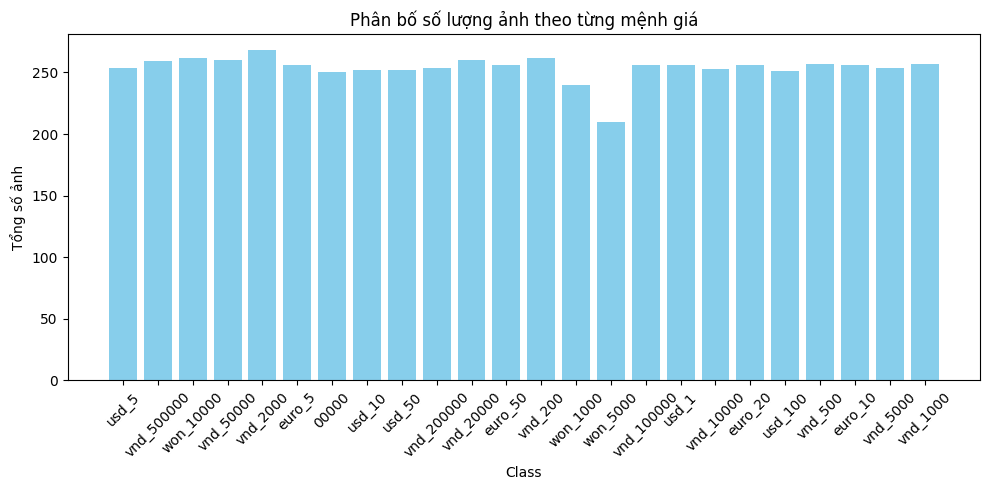

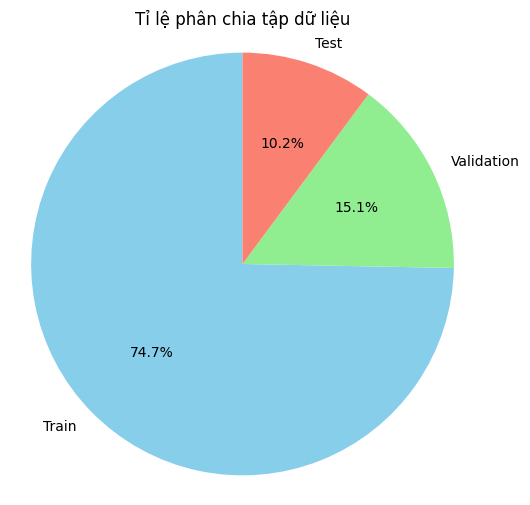

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# --- Hàm lấy số lượng ảnh theo từng lớp trong 1 tập ---
def get_class_counts(split_dir):
    counts = {}
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# --- Đường dẫn đến thư mục dữ liệu ---
target_base_dir = '/content/dataset_split'  # <- Đổi lại nếu cần

# --- Lấy số lượng ảnh từ từng tập ---
train_counts = get_class_counts(os.path.join(target_base_dir, 'train'))
val_counts = get_class_counts(os.path.join(target_base_dir, 'val'))
test_counts = get_class_counts(os.path.join(target_base_dir, 'test'))

# --- Gộp tổng số ảnh mỗi lớp (train + val + test) ---
total_counts = defaultdict(int)
for counts in [train_counts, val_counts, test_counts]:
    for class_name, count in counts.items():
        total_counts[class_name] += count

# --- Biểu đồ 1: Tổng số ảnh mỗi lớp ---
def plot_total_class_distribution(counts_dict, title):
    classes = list(counts_dict.keys())
    counts = list(counts_dict.values())

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Tổng số ảnh')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Biểu đồ 2: Tỉ lệ phân chia tổng thể tập dữ liệu ---
def plot_dataset_split_ratio(train_counts, val_counts, test_counts):
    total_train = sum(train_counts.values())
    total_val = sum(val_counts.values())
    total_test = sum(test_counts.values())

    sizes = [total_train, total_val, total_test]
    labels = ['Train', 'Validation', 'Test']
    colors = ['skyblue', 'lightgreen', 'salmon']

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Tỉ lệ phân chia tập dữ liệu')
    plt.axis('equal')
    plt.show()



# --- Gọi vẽ các biểu đồ ---
plot_total_class_distribution(total_counts, "Phân bố số lượng ảnh theo từng mệnh giá")
plot_dataset_split_ratio(train_counts, val_counts, test_counts)

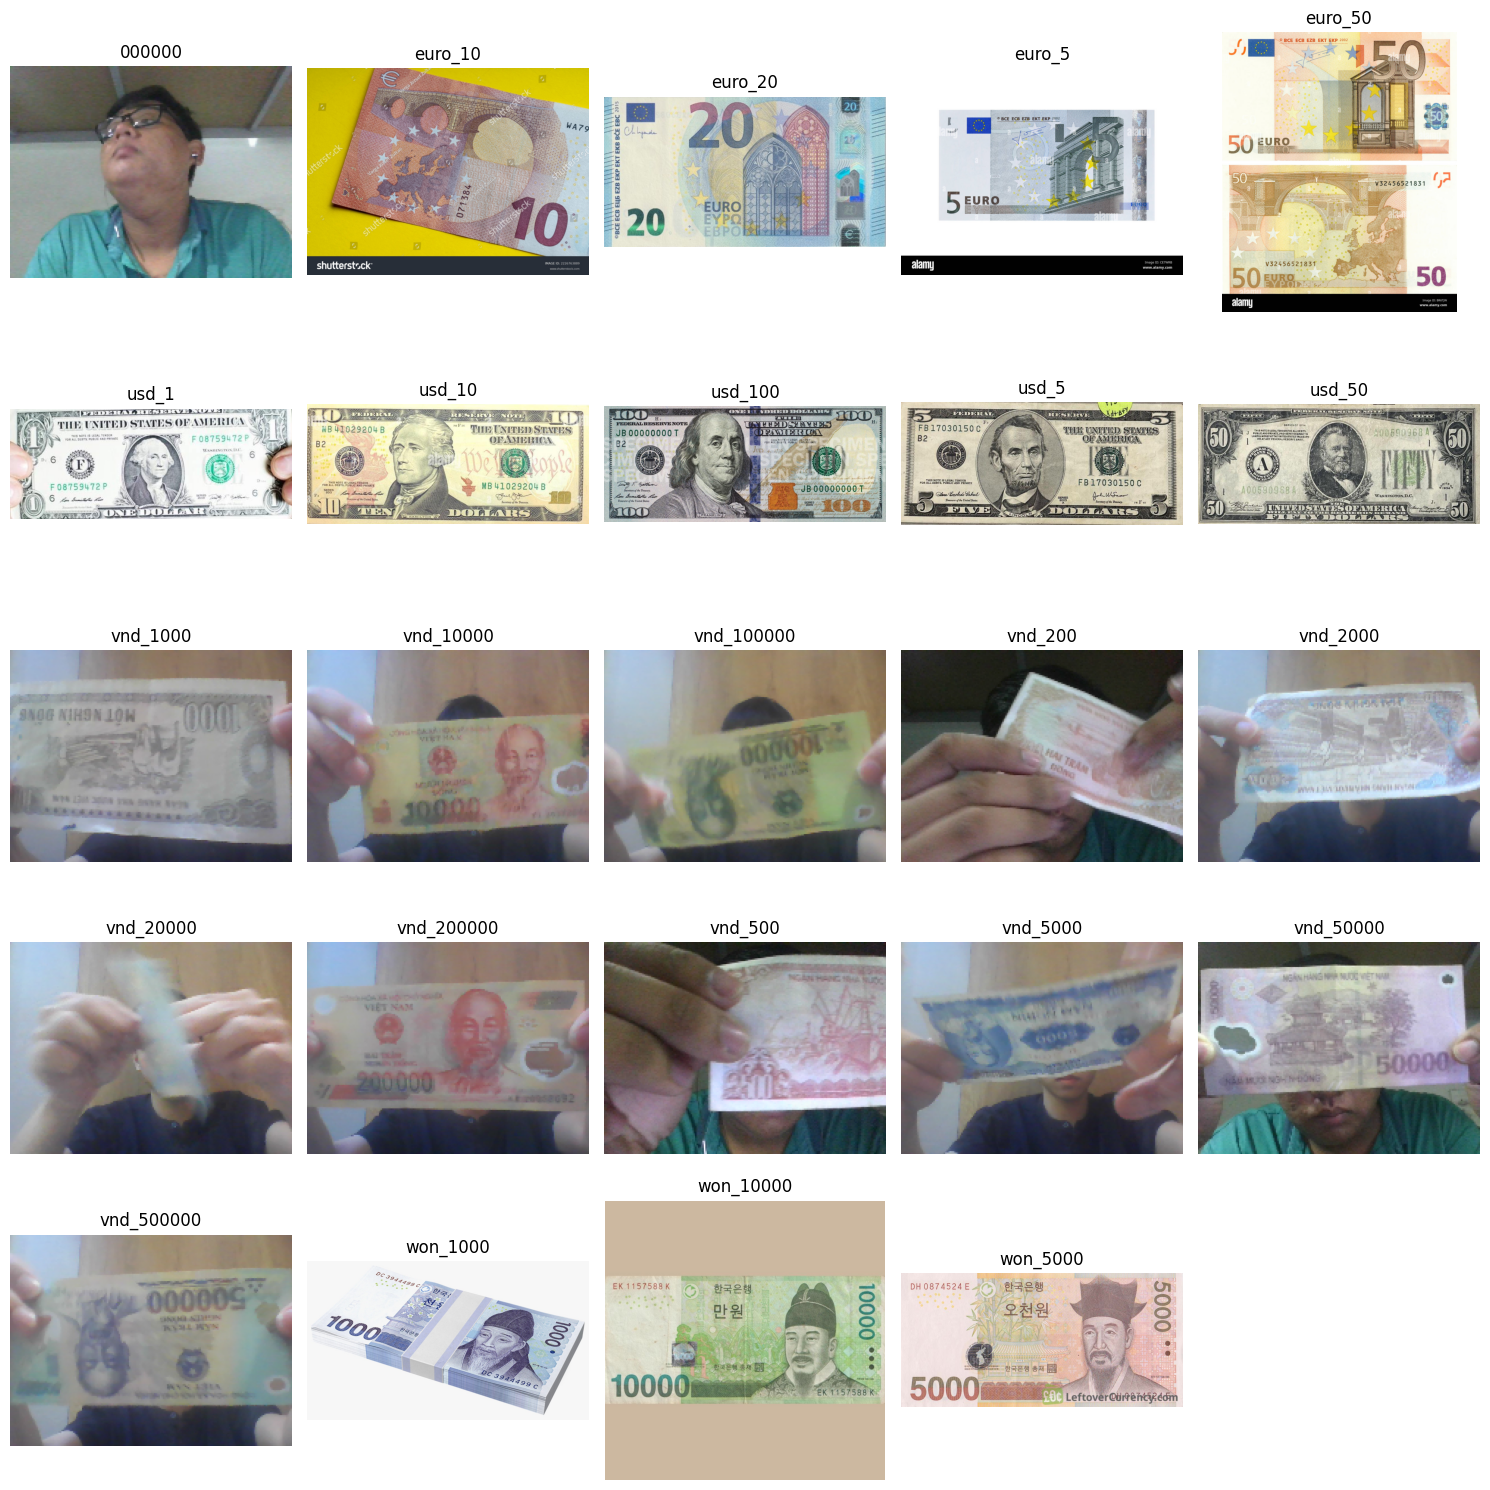

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

train_dir = os.path.join(target_base_dir, 'train')
class_names = sorted(os.listdir(train_dir))

num_classes = len(class_names)
cols = 5  # số cột muốn hiển thị
rows = math.ceil(num_classes / cols)  # tự tính số hàng cần thiết

plt.figure(figsize=(cols * 3, rows * 3))  # tăng kích thước phù hợp
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    img_name = os.listdir(class_path)[60]
    img_path = os.path.join(class_path, img_name)

    img = mpimg.imread(img_path)
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


Tăng cường & chuẩn hoá dữ liệu

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

DATA_DIR = '/content/dataset_split'

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'val'), transform=test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'test'), transform=test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


#Define custom Resnet18

In [ ]:
# Define BasicBlock & Custom ResNet18
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes=24):
        super(CustomResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion))
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Model
model = CustomResNet(BasicBlock, [2, 2, 2, 2]).to(DEVICE)


#Train

Epoch 1: Train Acc = 35.20% | Train Loss = 1.7966 | Val Acc = 41.87% | Val Loss = 1.5071
=> Saved best model at epoch 1 (Val Acc: 41.87%)
Epoch 2: Train Acc = 48.44% | Train Loss = 1.4129 | Val Acc = 48.59% | Val Loss = 1.4299
=> Saved best model at epoch 2 (Val Acc: 48.59%)
Epoch 3: Train Acc = 55.29% | Train Loss = 1.2014 | Val Acc = 52.55% | Val Loss = 1.5333
=> Saved best model at epoch 3 (Val Acc: 52.55%)
Epoch 4: Train Acc = 60.76% | Train Loss = 1.0803 | Val Acc = 63.11% | Val Loss = 0.9623
=> Saved best model at epoch 4 (Val Acc: 63.11%)
Epoch 5: Train Acc = 65.02% | Train Loss = 0.9608 | Val Acc = 62.99% | Val Loss = 1.1206
Epoch 6: Train Acc = 68.34% | Train Loss = 0.9000 | Val Acc = 63.53% | Val Loss = 1.1774
=> Saved best model at epoch 6 (Val Acc: 63.53%)
Epoch 7: Train Acc = 70.04% | Train Loss = 0.8544 | Val Acc = 61.91% | Val Loss = 1.0542
Epoch 8: Train Acc = 72.39% | Train Loss = 0.7778 | Val Acc = 74.33% | Val Loss = 0.6776
=> Saved best model at epoch 8 (Val Acc: 74

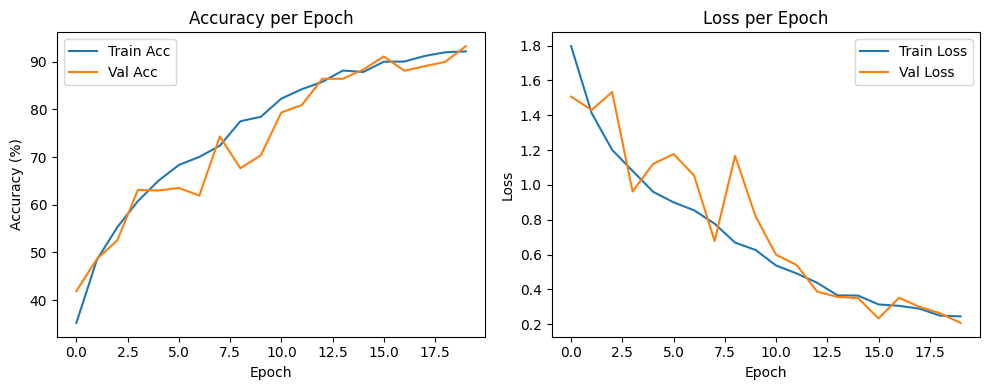

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Checkpoint paths
checkpoint_path = "/content/resnet18_checkpoint.pth"
best_model_path = "/content/resnet18_best.pth"

# Train function
def train(num_epochs=20):
    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []

    best_val_acc = 0.0  # For tracking best model

    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_running_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        avg_val_loss = val_running_loss / len(val_loader)

        print(f"Epoch {epoch+1}: "
              f"Train Acc = {train_acc:.2f}% | Train Loss = {avg_train_loss:.4f} | "
              f"Val Acc = {val_acc:.2f}% | Val Loss = {avg_val_loss:.4f}")

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)

        # Save checkpoint every epoch (overwrites)
        torch.save(model.state_dict(), checkpoint_path)

        # Save best model separately
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"=> Saved best model at epoch {epoch+1} (Val Acc: {val_acc:.2f}%)")

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy per Epoch')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(val_loss_list, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

train()


In [ ]:
#  Evaluation function
def evaluate():
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print(f"Val Accuracy: {acc * 100:.2f}%")
    print(f"F1-score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")

#  Evaluate model
evaluate()


Val Accuracy: 93.28%
F1-score: 0.9425
Recall: 0.9425


In [ ]:
print("Class mapping (index -> class name):")
for idx, class_name in enumerate(train_dataset.classes):
    print(f"{idx}: {class_name}")


Class mapping (index -> class name):
0: 00000
1: euro_10
2: euro_20
3: euro_5
4: euro_50
5: usd_1
6: usd_10
7: usd_100
8: usd_5
9: usd_50
10: vnd_1000
11: vnd_10000
12: vnd_100000
13: vnd_200
14: vnd_2000
15: vnd_20000
16: vnd_200000
17: vnd_500
18: vnd_5000
19: vnd_50000
20: vnd_500000
21: won_1000
22: won_10000
23: won_5000


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
import torch


#  Hàm đánh giá trên tập test
def evaluate_test():
    model.load_state_dict(torch.load(best_model_path))
    model.to(DEVICE)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print("📊 Đánh giá trên tập TEST:")
    print(f"🎯 Accuracy: {acc * 100:.2f}%")
    print(f"🔁 F1-score (macro): {f1:.4f}")
    print(f"🔍 Recall (macro): {recall:.4f}")
    print("\n📋 Classification Report:")
    print(classification_report(all_labels, all_preds))
evaluate_test()

📊 Đánh giá trên tập TEST:
🎯 Accuracy: 93.02%
🔁 F1-score (macro): 0.9362
🔍 Recall (macro): 0.9366

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       1.00      1.00      1.00        32
           2       0.93      1.00      0.96        26
           3       1.00      0.93      0.96        27
           4       0.92      1.00      0.96        23
           5       1.00      0.88      0.94        58
           6       0.95      0.97      0.96        59
           7       0.85      0.98      0.91        58
           8       0.94      0.98      0.96        62
           9       1.00      0.88      0.94        68
          10       1.00      0.76      0.86        66
          11       0.97      0.94      0.95        66
          12       0.97      0.85      0.90        66
          13       0.82      0.92      0.87        25
          14       0.87      0.98      0.92        66
          15

#Test với sample


Prediction: usd_10 (99.5%)


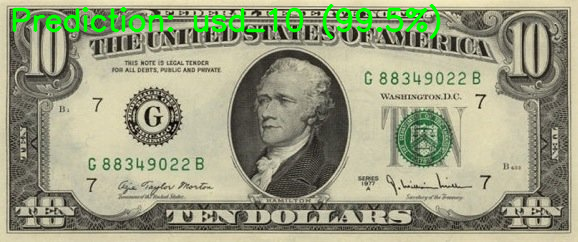

In [ ]:
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import os


# Danh sách các lớp
class_names = [
    '000000', 'euro_10', 'euro_20', 'euro_5', 'euro_50',
    'usd_1', 'usd_10', 'usd_100', 'usd_5', 'usd_50',
    'vnd_1000', 'vnd_10000', 'vnd_100000', 'vnd_200', 'vnd_2000',
    'vnd_20000', 'vnd_200000', 'vnd_500', 'vnd_5000', 'vnd_50000',
    'vnd_500000', 'won_1000', 'won_10000', 'won_5000'
]

# Thiết bị
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'/resnet18_best.pth'

# Khởi tạo model
model = CustomResNet(BasicBlock, [2, 2, 2, 2], num_classes=len(class_names))
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

# Transform ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Kiểm tra ảnh tồn tại
image_path = r'/10usd.jpg'

if not os.path.exists(image_path):
    print("❌ Ảnh không tồn tại. Vui lòng tải ảnh lên.")
    exit()

img_bgr = cv2.imread(image_path)
if img_bgr is None:
    print("❌ Không thể đọc ảnh. Có thể định dạng không hợp lệ.")
    exit()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
pil_img = Image.fromarray(img_rgb)

# Tiền xử lý
input_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

# Dự đoán
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.softmax(output, dim=1)
    max_prob, predicted = torch.max(probabilities, 1)
    predicted_class = class_names[predicted.item()]
    confidence = max_prob.item()

# Hiển thị kết quả
if confidence >= 0.5:
    label = f'Prediction: {predicted_class} ({confidence*100:.1f}%)'
else:
    label = 'Prediction: ???'
print(label)
# Ghi nhãn lên ảnh và hiển thị
cv2.putText(img_bgr, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
            1, (0, 255, 0), 2, cv2.LINE_AA)
from google.colab.patches import cv2_imshow
cv2_imshow(img_bgr)

cv2.waitKey(0)
cv2.destroyAllWindows()
